In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!apt-get update -qq && apt-get install -y -qq p7zip-full


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
!7z x "/content/drive/MyDrive/BrushlessMotor.7z" -o"/content/drive/MyDrive/BrushlessMotorExtracted" -y



7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 1577018050 bytes (1504 MiB)

Extracting archive: /content/drive/MyDrive/BrushlessMotor.7z
--
Path = /content/drive/MyDrive/BrushlessMotor.7z
Type = 7z
Physical Size = 1577018050
Headers Size = 36645
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      0% 4 - BrushlessMotor/test/attributes_anomaly_target_test.csv                                                                 0% 9 - BrushlessMotor/test/imp23absu_mic_20240423_10_24_07_DataLog_0.parquet

In [ ]:
!ls -lh "/content/drive/MyDrive/BrushlessMotorExtracted" | head -20


total 4.0K
drwx------ 4 root root 4.0K Jul  3  2024 BrushlessMotor


In [17]:


import os, glob
base = "/content/drive/MyDrive/BrushlessMotorExtracted/BrushlessMotor"  # adjust if needed
out_features_path = "/content/drive/MyDrive/imad_brushless_features_all.parquet"
out_model_path = "/content/drive/MyDrive/imad_brushless_isoforest_all.joblib"

# find parquet files recursively
parquet_files = sorted(glob.glob(os.path.join(base, "**", "*.parquet"), recursive=True))
len(parquet_files)

4779

In [18]:
import numpy as np, pandas as pd, math

def extract_features_from_signal(sig):
    out = {}
    out['n'] = int(len(sig))
    out['mean'] = float(np.mean(sig))
    out['std'] = float(np.std(sig))
    out['rms'] = float(math.sqrt(np.mean(sig**2)))
    out['max'] = float(np.max(sig))
    out['min'] = float(np.min(sig))
    out['ptp'] = float(out['max'] - out['min'])
    out['kurtosis'] = float(pd.Series(sig).kurtosis())
    out['skew'] = float(pd.Series(sig).skew())
    # coarse FFT power features
    try:
        fft = np.fft.rfft(sig)
        psd = np.abs(fft)**2
        out['total_power'] = float(psd.sum())
        half = len(psd)//2
        low = float(psd[:max(1,half//4)].sum())
        high = float(psd[max(1,half//2):].sum()) if half>1 else float(psd[-1])
        out['low_high_ratio'] = float((low+1e-12)/(high+1e-12))
    except Exception:
        out['total_power'] = np.nan
        out['low_high_ratio'] = np.nan
    return out


In [19]:
import os, tqdm, pyarrow as pa, pyarrow.parquet as pq

# PARAMETERS (tune)
process_all = True        # set False to process only first N
batch_size = 500          # number of files processed per batch (reduce if memory issues)
start_from_batch = 0      # set >0 to resume from a later batch
max_files = None          # None => all files; or set e.g., 2000 to limit

files = parquet_files if max_files is None else parquet_files[:max_files]
total_files = len(files)
print("Total files to process:", total_files)

# If features output already exists, we'll append; otherwise create new
if os.path.exists(out_features_path):
    print("Existing features file found at", out_features_path)
    existing_df = pd.read_parquet(out_features_path)
    processed_files_set = set(existing_df['file'].tolist())
    print("Already processed files:", len(processed_files_set))
else:
    existing_df = None
    processed_files_set = set()

# batch loop
batches = []
for i in range(start_from_batch, (total_files + batch_size - 1)//batch_size):
    b_start = i * batch_size
    b_end = min((i+1) * batch_size, total_files)
    batch_files = files[b_start:b_end]
    # skip files already processed (resumable)
    batch_files = [f for f in batch_files if os.path.basename(f) not in processed_files_set]
    if len(batch_files) == 0:
        print(f"Batch {i} (files {b_start}-{b_end}) already processed, skipping.")
        continue

    rows = []
    for path in tqdm.tqdm(batch_files, desc=f"Batch {i}"):
        try:
            tmp = pd.read_parquet(path)
            # ensure waveform column exists
            if 'MIC [Waveform]' in tmp.columns:
                sig = tmp['MIC [Waveform]'].astype(float).values
            else:
                # fallback: choose first numeric column excluding 'Time' (defensive)
                num_cols = [c for c in tmp.columns if np.issubdtype(tmp[c].dtype, np.number) and 'time' not in c.lower()]
                if len(num_cols) == 0:
                    raise ValueError("No numeric signal column found")
                sig = tmp[num_cols[0]].astype(float).values

            feats = extract_features_from_signal(sig)
            feats['file'] = os.path.basename(path)
            feats['path'] = path
            rows.append(feats)
        except Exception as e:
            # save failure info, but do not stop
            rows.append({'file': os.path.basename(path), 'path': path, 'error': str(e)})
            continue

    batch_df = pd.DataFrame(rows)
    # append to the master parquet (append mode via pyarrow)
    if os.path.exists(out_features_path):
        # read existing, concat, and overwrite (safe)
        tmp_exist = pd.read_parquet(out_features_path)
        merged = pd.concat([tmp_exist, batch_df], ignore_index=True)
        merged.to_parquet(out_features_path, index=False)
    else:
        batch_df.to_parquet(out_features_path, index=False)

    print(f"Saved batch {i} features to {out_features_path} (processed files {b_start}-{b_end})")

    # optional: break early if not processing all
    if not process_all:
        print("process_all==False: stopping after first batch.")
        break


Total files to process: 4779


Batch 0: 100%|██████████| 500/500 [00:28<00:00, 17.48it/s]


Saved batch 0 features to /content/drive/MyDrive/imad_brushless_features_all.parquet (processed files 0-500)


Batch 1: 100%|██████████| 500/500 [00:14<00:00, 35.55it/s]


Saved batch 1 features to /content/drive/MyDrive/imad_brushless_features_all.parquet (processed files 500-1000)


Batch 2: 100%|██████████| 500/500 [00:17<00:00, 29.32it/s]


Saved batch 2 features to /content/drive/MyDrive/imad_brushless_features_all.parquet (processed files 1000-1500)


Batch 3: 100%|██████████| 500/500 [00:16<00:00, 29.49it/s]


Saved batch 3 features to /content/drive/MyDrive/imad_brushless_features_all.parquet (processed files 1500-2000)


Batch 4: 100%|██████████| 500/500 [00:14<00:00, 33.79it/s]


Saved batch 4 features to /content/drive/MyDrive/imad_brushless_features_all.parquet (processed files 2000-2500)


Batch 5: 100%|██████████| 500/500 [00:14<00:00, 33.44it/s]


Saved batch 5 features to /content/drive/MyDrive/imad_brushless_features_all.parquet (processed files 2500-3000)


Batch 6: 100%|██████████| 500/500 [00:13<00:00, 36.11it/s]


Saved batch 6 features to /content/drive/MyDrive/imad_brushless_features_all.parquet (processed files 3000-3500)


Batch 7: 100%|██████████| 500/500 [00:12<00:00, 41.22it/s]


Saved batch 7 features to /content/drive/MyDrive/imad_brushless_features_all.parquet (processed files 3500-4000)


Batch 8: 100%|██████████| 500/500 [00:13<00:00, 37.37it/s]


Saved batch 8 features to /content/drive/MyDrive/imad_brushless_features_all.parquet (processed files 4000-4500)


Batch 9: 100%|██████████| 279/279 [00:06<00:00, 41.67it/s]


Saved batch 9 features to /content/drive/MyDrive/imad_brushless_features_all.parquet (processed files 4500-4779)


In [20]:
import os, tqdm, pyarrow as pa, pyarrow.parquet as pq

# PARAMETERS (tune)
process_all = True        # set False to process only first N
batch_size = 500          # number of files processed per batch (reduce if memory issues)
start_from_batch = 0      # set >0 to resume from a later batch
max_files = None          # None => all files; or set e.g., 2000 to limit

files = parquet_files if max_files is None else parquet_files[:max_files]
total_files = len(files)
print("Total files to process:", total_files)

# If features output already exists, we'll append; otherwise create new
if os.path.exists(out_features_path):
    print("Existing features file found at", out_features_path)
    existing_df = pd.read_parquet(out_features_path)
    processed_files_set = set(existing_df['file'].tolist())
    print("Already processed files:", len(processed_files_set))
else:
    existing_df = None
    processed_files_set = set()

# batch loop
batches = []
for i in range(start_from_batch, (total_files + batch_size - 1)//batch_size):
    b_start = i * batch_size
    b_end = min((i+1) * batch_size, total_files)
    batch_files = files[b_start:b_end]
    # skip files already processed (resumable)
    batch_files = [f for f in batch_files if os.path.basename(f) not in processed_files_set]
    if len(batch_files) == 0:
        print(f"Batch {i} (files {b_start}-{b_end}) already processed, skipping.")
        continue

    rows = []
    for path in tqdm.tqdm(batch_files, desc=f"Batch {i}"):
        try:
            tmp = pd.read_parquet(path)
            # ensure waveform column exists
            if 'MIC [Waveform]' in tmp.columns:
                sig = tmp['MIC [Waveform]'].astype(float).values
            else:
                # fallback: choose first numeric column excluding 'Time' (defensive)
                num_cols = [c for c in tmp.columns if np.issubdtype(tmp[c].dtype, np.number) and 'time' not in c.lower()]
                if len(num_cols) == 0:
                    raise ValueError("No numeric signal column found")
                sig = tmp[num_cols[0]].astype(float).values

            feats = extract_features_from_signal(sig)
            feats['file'] = os.path.basename(path)
            feats['path'] = path
            rows.append(feats)
        except Exception as e:
            # save failure info, but do not stop
            rows.append({'file': os.path.basename(path), 'path': path, 'error': str(e)})
            continue

    batch_df = pd.DataFrame(rows)
    # append to the master parquet (append mode via pyarrow)
    if os.path.exists(out_features_path):
        # read existing, concat, and overwrite (safe)
        tmp_exist = pd.read_parquet(out_features_path)
        merged = pd.concat([tmp_exist, batch_df], ignore_index=True)
        merged.to_parquet(out_features_path, index=False)
    else:
        batch_df.to_parquet(out_features_path, index=False)

    print(f"Saved batch {i} features to {out_features_path} (processed files {b_start}-{b_end})")

    # optional: break early if not processing all
    if not process_all:
        print("process_all==False: stopping after first batch.")
        break


Total files to process: 4779
Existing features file found at /content/drive/MyDrive/imad_brushless_features_all.parquet
Already processed files: 4779
Batch 0 (files 0-500) already processed, skipping.
Batch 1 (files 500-1000) already processed, skipping.
Batch 2 (files 1000-1500) already processed, skipping.
Batch 3 (files 1500-2000) already processed, skipping.
Batch 4 (files 2000-2500) already processed, skipping.
Batch 5 (files 2500-3000) already processed, skipping.
Batch 6 (files 3000-3500) already processed, skipping.
Batch 7 (files 3500-4000) already processed, skipping.
Batch 8 (files 4000-4500) already processed, skipping.
Batch 9 (files 4500-4779) already processed, skipping.


In [21]:
# once batches complete, load the complete features file
features_df = pd.read_parquet(out_features_path)
print("Total feature rows:", len(features_df))
display(features_df.head())

# remove rows with errors (if any)
if 'error' in features_df.columns:
    errors = features_df[features_df['error'].notna()]
    print("Files failed:", len(errors))
    features_df = features_df[features_df['error'].isna()].drop(columns=['error'])


Total feature rows: 4779


,n,mean,std,rms,max,min,ptp,kurtosis,skew,total_power,low_high_ratio,file,path
0,83200,-0.006001,0.224201,0.224282,1.118121,-1.027657,2.145778,0.950786,0.090733,1.742270e+08,9.412484,imp23absu_mic_20240423_10_20_50_DataLog_0.parquet,/content/drive/MyDrive/BrushlessMotorExtracted...
1,83200,-0.013983,0.224053,0.224489,0.959388,-1.024738,1.984126,0.088621,-0.042029,1.751010e+08,6.461985,imp23absu_mic_20240423_10_21_58_DataLog_0.parquet,/content/drive/MyDrive/BrushlessMotorExtracted...
2,83200,-0.008770,0.225730,0.225901,1.065674,-1.020102,2.085776,0.633555,0.122115,1.768910e+08,11.308919,imp23absu_mic_20240423_10_24_07_DataLog_0.parquet,/content/drive/MyDrive/BrushlessMotorExtracted...
3,83200,-0.007946,0.223628,0.223769,0.984339,-0.870549,1.854888,-0.110498,0.056923,1.735256e+08,14.492839,imp23absu_mic_20240423_10_24_37_DataLog_0.parquet,/content/drive/MyDrive/BrushlessMotorExtracted...
4,83200,0.015556,0.225041,0.225578,0.901593,-0.968681,1.870274,-0.091855,0.007994,1.769579e+08,14.139310,imp23absu_mic_20240423_10_26_46_DataLog_0.parquet,/content/drive/MyDrive/BrushlessMotorExtracted...


In [22]:
from sklearn.ensemble import IsolationForest
feat_cols = ['mean','std','rms','ptp','kurtosis','skew','total_power','low_high_ratio']

# ensure columns exist
feat_cols = [c for c in feat_cols if c in features_df.columns]
X = features_df[feat_cols].fillna(0).values

iso = IsolationForest(n_estimators=300, contamination=0.02, random_state=42, n_jobs=-1)
iso.fit(X)
features_df['anomaly_score'] = -iso.decision_function(X)
features_df = features_df.sort_values('anomaly_score', ascending=False).reset_index(drop=True)

# save results & model
features_df.to_parquet("/content/drive/MyDrive/imad_brushless_features_all_with_scores.parquet", index=False)
import joblib
joblib.dump(iso, out_model_path)
print("Saved features and model to Drive.")


Saved features and model to Drive.


In [24]:
import re
import numpy as np, pandas as pd, math

def get_waveform_column(df):
    """
    Tries to detect which column holds the waveform signal.
    Returns the column name.
    """
    cols = list(df.columns)
    # look for columns containing any of these substrings
    candidates = [c for c in cols if re.search(r'mic|wave|audio|signal|vib|sound', c, re.I)]
    if candidates:
        return candidates[0]
    # fallback to first numeric column (not time)
    numeric_cols = [c for c in cols if np.issubdtype(df[c].dtype, np.number) and not re.search(r'time', c, re.I)]
    return numeric_cols[0] if numeric_cols else cols[1]

def extract_features_from_signal(sig):
    out = {}
    out['n'] = len(sig)
    out['mean'] = float(np.mean(sig))
    out['std'] = float(np.std(sig))
    out['rms'] = float(math.sqrt(np.mean(sig**2)))
    out['max'] = float(np.max(sig))
    out['min'] = float(np.min(sig))
    out['ptp'] = float(out['max'] - out['min'])
    out['kurtosis'] = float(pd.Series(sig).kurtosis())
    out['skew'] = float(pd.Series(sig).skew())
    try:
        fft = np.fft.rfft(sig)
        psd = np.abs(fft)**2
        out['total_power'] = float(psd.sum())
        half = len(psd)//2
        low = float(psd[:max(1,half//4)].sum())
        high = float(psd[max(1,half//2):].sum()) if half>1 else float(psd[-1])
        out['low_high_ratio'] = float((low+1e-12)/(high+1e-12))
    except Exception:
        out['total_power'] = np.nan
        out['low_high_ratio'] = np.nan
    return out


In [25]:
import os, tqdm

rows = []
for idx, path in enumerate(tqdm.tqdm(parquet_files, desc="Processing files")):
    try:
        df = pd.read_parquet(path)
        wave_col = get_waveform_column(df)
        if idx < 3:  # show first few detections
            print(f"[{idx}] {os.path.basename(path)} → waveform column: {wave_col}")

        sig = df[wave_col].astype(float).values
        feats = extract_features_from_signal(sig)
        feats['file'] = os.path.basename(path)
        feats['path'] = path
        feats['wave_col'] = wave_col
        rows.append(feats)
    except Exception as e:
        rows.append({'file': os.path.basename(path), 'path': path, 'error': str(e)})
        continue

features_df = pd.DataFrame(rows)
print("Extracted features for:", len(features_df), "files")
display(features_df.head())


Processing files:   0%|          | 2/4779 [00:00<08:05,  9.83it/s]

[0] imp23absu_mic_20240423_10_20_50_DataLog_0.parquet → waveform column: MIC [Waveform]
[1] imp23absu_mic_20240423_10_21_58_DataLog_0.parquet → waveform column: MIC [Waveform]


Processing files:   0%|          | 4/4779 [00:00<09:43,  8.18it/s]

[2] imp23absu_mic_20240423_10_24_07_DataLog_0.parquet → waveform column: MIC [Waveform]


Processing files: 100%|██████████| 4779/4779 [02:11<00:00, 36.44it/s]


Extracted features for: 4779 files


,n,mean,std,rms,max,min,ptp,kurtosis,skew,total_power,low_high_ratio,file,path,wave_col
0,83200,-0.006001,0.224201,0.224282,1.118121,-1.027657,2.145778,0.950786,0.090733,1.742270e+08,9.412484,imp23absu_mic_20240423_10_20_50_DataLog_0.parquet,/content/drive/MyDrive/BrushlessMotorExtracted...,MIC [Waveform]
1,83200,-0.013983,0.224053,0.224489,0.959388,-1.024738,1.984126,0.088621,-0.042029,1.751010e+08,6.461985,imp23absu_mic_20240423_10_21_58_DataLog_0.parquet,/content/drive/MyDrive/BrushlessMotorExtracted...,MIC [Waveform]
2,83200,-0.008770,0.225730,0.225901,1.065674,-1.020102,2.085776,0.633555,0.122115,1.768910e+08,11.308919,imp23absu_mic_20240423_10_24_07_DataLog_0.parquet,/content/drive/MyDrive/BrushlessMotorExtracted...,MIC [Waveform]
3,83200,-0.007946,0.223628,0.223769,0.984339,-0.870549,1.854888,-0.110498,0.056923,1.735256e+08,14.492839,imp23absu_mic_20240423_10_24_37_DataLog_0.parquet,/content/drive/MyDrive/BrushlessMotorExtracted...,MIC [Waveform]
4,83200,0.015556,0.225041,0.225578,0.901593,-0.968681,1.870274,-0.091855,0.007994,1.769579e+08,14.139310,imp23absu_mic_20240423_10_26_46_DataLog_0.parquet,/content/drive/MyDrive/BrushlessMotorExtracted...,MIC [Waveform]


In [26]:
from sklearn.ensemble import IsolationForest
import joblib
import numpy as np

# feature columns to use (exists in your features_df)
feat_cols = ['mean','std','rms','ptp','kurtosis','skew','total_power','low_high_ratio']
feat_cols = [c for c in feat_cols if c in features_df.columns]

X = features_df[feat_cols].fillna(0).values

iso = IsolationForest(n_estimators=300, contamination=0.02, random_state=42, n_jobs=-1)
iso.fit(X)
features_df['anomaly_score'] = -iso.decision_function(X)   # higher == more anomalous

# sort by anomaly score (desc)
features_df = features_df.sort_values('anomaly_score', ascending=False).reset_index(drop=True)

# save features + scores
out_path = "/content/drive/MyDrive/imad_brushless_features_all_with_scores.parquet"
features_df.to_parquet(out_path, index=False)
joblib.dump(iso, "/content/drive/MyDrive/imad_brushless_isoforest_all.joblib")

print("Saved features with scores to:", out_path)
print("Saved IsolationForest model to: /content/drive/MyDrive/imad_brushless_isoforest_all.joblib")


Saved features with scores to: /content/drive/MyDrive/imad_brushless_features_all_with_scores.parquet
Saved IsolationForest model to: /content/drive/MyDrive/imad_brushless_isoforest_all.joblib


In [27]:
from IPython.display import display
display(features_df[['file','anomaly_score','mean','std','rms']].head(20))


,file,anomaly_score,mean,std,rms
0,ism330dhcx_gyro_20240423_17_38_11_DataLog_0.pa...,0.066676,443.091850,7843.534959,7856.040418
1,ism330dhcx_gyro_20240423_16_19_25_DataLog_0.pa...,0.056093,397.628827,22102.810215,22106.386590
2,ism330dhcx_gyro_20240423_12_54_24_DataLog_0.pa...,0.055761,439.235144,8807.557217,8818.502800
3,ism330dhcx_gyro_20240423_11_42_46_DataLog_0.pa...,0.053108,427.361272,8175.071202,8186.233983
4,ism330dhcx_gyro_20240423_11_37_37_DataLog_0.pa...,0.053100,430.055249,8133.134892,8144.496957
5,ism330dhcx_gyro_20240423_12_44_43_DataLog_0.pa...,0.049092,438.646544,8814.781513,8825.688863
6,ism330dhcx_gyro_20240423_12_16_58_DataLog_0.pa...,0.047896,438.050398,8486.330438,8497.628638
7,ism330dhcx_gyro_20240423_12_58_08_DataLog_0.pa...,0.046738,447.498922,8954.321999,8965.497072
8,ism330dhcx_gyro_20240423_16_55_21_DataLog_0.pa...,0.045539,439.888958,8228.117607,8239.867818
9,ism330dhcx_gyro_20240423_18_22_40_DataLog_0.pa...,0.043669,410.649813,23973.983871,23977.500618


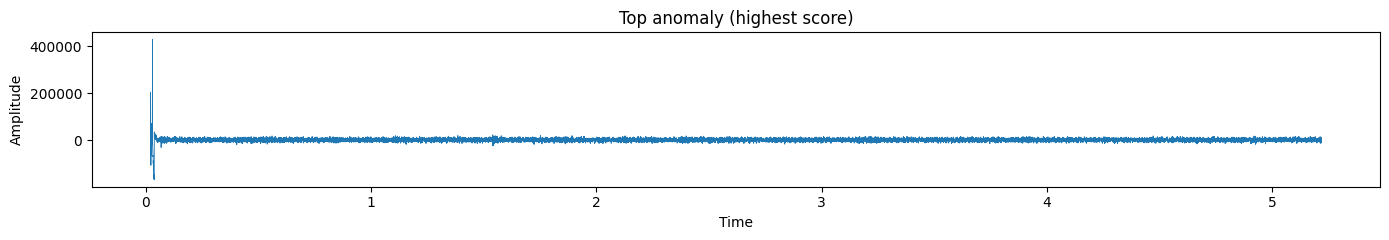

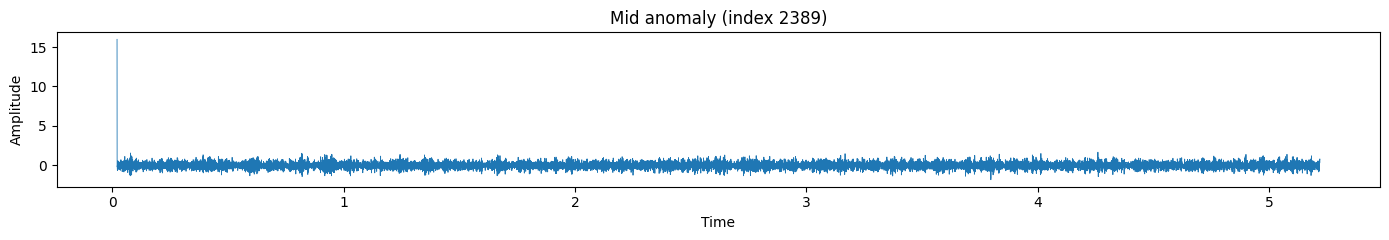

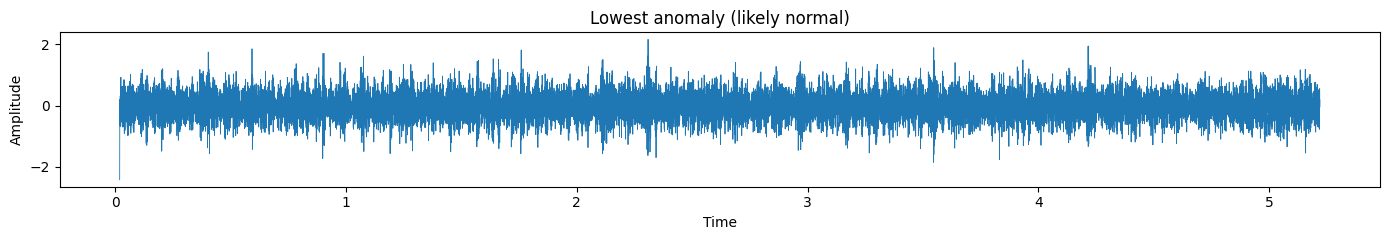

In [28]:
import matplotlib.pyplot as plt

def plot_signal_by_row(row, title=None):
    path = row['path']
    df_sig = pd.read_parquet(path)
    # detect waveform col if different
    wave_col = row.get('wave_col', 'MIC [Waveform]')
    t = df_sig['Time'] if 'Time' in df_sig.columns else range(len(df_sig))
    sig = df_sig[wave_col].astype(float).values
    plt.figure(figsize=(14,2.5))
    plt.plot(t, sig, lw=0.6)
    plt.title(title or f"{row['file']}  score={row['anomaly_score']:.4f}")
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

# top anomaly
plot_signal_by_row(features_df.iloc[0], title="Top anomaly (highest score)")

# medium anomaly (middle of list)
mid_idx = len(features_df)//2
plot_signal_by_row(features_df.iloc[mid_idx], title=f"Mid anomaly (index {mid_idx})")

# low anomaly (lowest score)
plot_signal_by_row(features_df.iloc[-1], title="Lowest anomaly (likely normal)")


In [29]:
display(features_df['anomaly_score'].describe().to_frame().T)
# save top N to CSV for quick inspection
features_df[['file','anomaly_score']].head(100).to_csv("/content/drive/MyDrive/imad_top100_anomalies.csv", index=False)
print("Saved top-100 anomalies CSV to /content/drive/MyDrive/imad_top100_anomalies.csv")


,count,mean,std,min,25%,50%,75%,max
anomaly_score,4779.0,-0.15778,0.062355,-0.243779,-0.208222,-0.172395,-0.123485,0.066676


Saved top-100 anomalies CSV to /content/drive/MyDrive/imad_top100_anomalies.csv
